In [251]:
from error_prop_tools import *
import pyzx as zx
import numpy as np
import scipy as sp
import sympy as sy
import random
import matplotlib.pyplot as plt
from fractions import Fraction
import quimb.tensor as qtn
import pprint as pp

--- Generated Grid Map for d=3 ---
[[0, 0, 'X0', 0, 0, 0, 0],
 [0, 'd0', 0, 'd1', 0, 'd2', 0],
 [0, 0, 'Z0', 0, 'X1', 0, 'Z1'],
 [0, 'd3', 0, 'd4', 0, 'd5', 0],
 ['Z2', 0, 'X2', 0, 'Z3', 0, 0],
 [0, 'd6', 0, 'd7', 0, 'd8', 0],
 [0, 0, 0, 0, 'X3', 0, 0]]


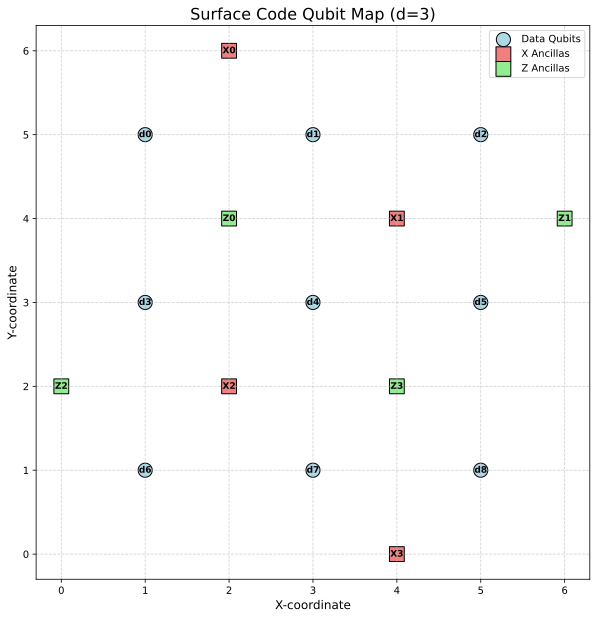


--- Generated PyZX Qubit Map (Corrected Coordinates) ---
{0: (1, 1),
 1: (1, 3),
 2: (1, 5),
 3: (3, 1),
 4: (3, 3),
 5: (3, 5),
 6: (5, 1),
 7: (5, 3),
 8: (5, 5),
 9: (0, 2),
 10: (2, 2),
 11: (2, 4),
 12: (2, 6),
 13: (4, 0),
 14: (4, 2),
 15: (4, 4),
 16: (6, 4),
 17: (3, 2)}


In [252]:
DISTANCE = 3

_, sorted_ancillas = generate_pyzx_and_plot_rotated_code(DISTANCE)

print("\n--- Generated PyZX Qubit Map (Corrected Coordinates) ---")

pyzx_map_rotated = {2: (1, 5),
                    5: (3, 5),
                    8: (5, 5),
                    1: (1, 3),
                    4: (3, 3),
                    7: (5, 3),
                    0: (1, 1),
                    3: (3, 1),
                    6: (5, 1),
                    12: (2, 6),
                    11: (2, 4),
                    15: (4, 4),
                    16: (6, 4),
                    9: (0, 2),
                    10: (2, 2),
                    14: (4, 2),
                    13: (4, 0),
                    17: (3, 2),
                    }

pprint.pprint(pyzx_map_rotated)

In [253]:
custom_orders = {
    'Z0': [1, 2, 0, 3],
    'X1': [1, 2, 0, 3],
    'X2': [1, 2, 0, 3],
    'Z3': [1, 2, 0, 3]
}
custom_qasm_string = generate_surface_code_qasm(DISTANCE, custom_cnot_orderings=custom_orders)
g = zx.sqasm(custom_qasm_string, simplify=False)
zx.id_simp(g)
g.map_qubits(pyzx_map_rotated)

In [254]:
encoder = zx.Graph()
for i in range(9):
    a = encoder.add_vertex(zx.VertexType.X, qubit = i, row = 1, phase=0)
    b = encoder.add_vertex(zx.VertexType.BOUNDARY, qubit = i, row = 2, phase=0)
    encoder.add_edge((a, b))
for i in [10, 12, 13, 15]:
    a = encoder.add_vertex(zx.VertexType.Z, qubit = i , row = 1, phase=0)

#Z0
encoder.add_edge((18, 0))
encoder.add_edge((18, 2))
encoder.add_edge((18, 6))
encoder.add_edge((18, 8))
#Z1
encoder.add_edge((19, 4))
encoder.add_edge((19, 10))

#Z2
encoder.add_edge((20, 6))
encoder.add_edge((20, 12))

#Z3
encoder.add_edge((21, 8))
encoder.add_edge((21, 10))
encoder.add_edge((21, 14))
encoder.add_edge((21, 16))

#logical input
in0 = encoder.add_vertex(zx.VertexType.Z, qubit = 17, row = 0, phase=0)
in1 = encoder.add_vertex(zx.VertexType.BOUNDARY, qubit = 17, row = -1, phase=0)
encoder.add_edge((in0, in1))

encoder.add_edge((in0, 0))
encoder.add_edge((in0, 6))
encoder.add_edge((in0, 12))

#map n draw
encoder.set_outputs([1, 3, 5, 7, 9, 11, 13, 15, 17])
encoder.map_qubits(pyzx_map_rotated)
encoder_c = encoder.copy()

In [255]:
print(corr_s)


qreg d[9];
x d[0];
z d[0];
x d[1];
z d[1];
x d[2];
z d[2];
x d[3];
z d[3];
x d[4];
z d[4];
x d[5];
z d[5];
x d[6];
z d[6];
x d[7];
z d[7];
x d[8];
z d[8];



In [256]:
gc = g.copy()
gc.apply_state('/////////00000000')
gc.apply_effect('/////////00000000')
process = encoder_c.copy()
process.compose(gc)
symbols = sy.symbols('X0 Z0 X1 Z1 Z2 X2 Z3 X3')
for i in range(8):
    process.set_phase(i+89, symbols[i])

corr_s = """
qreg d[9];
"""
for i in range(9):
    corr_s += f"x d[{i}];\n"
    corr_s += f"z d[{i}];\n"

corr = zx.sqasm(corr_s)
corr.map_qubits(pyzx_map_rotated)

x_symbols = sy.symbols('x_d:9')
z_symbols = sy.symbols('z_d:9')

for i, j in enumerate(range(0, 17, 2)):
    corr.set_phase(9+j, x_symbols[i])
    corr.set_phase(9+j+1, z_symbols[i])

process.compose(corr)
process.compose(encoder_c.adjoint())
zx.draw(process, True)


$x_{d0}$, ect are all functions of the stabilizer measurment values $X0$ ect, this displays the whole round in 1 go but actually we do multiple rounds and we dont actually apply the corrections on the QC, this can be accounted for in modeling the noise model ie make the correction layer 0 noise, also the stabilizer values are naturally measured before the correction is applied.